In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import ProjectPacks as pp
import ProjectFuncs as pf
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [2]:
## Choose number of timeslots
timeslots= 200
A_mod,l_mod,m_mod,ut,vt,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

nbl= int(len(ut)*(len(ut)-1)/2)
endt= 5
t = np.arange(0, endt, endt/timeslots)          #The points at which we will be taking our "measurements"
noise = 0.000*(np.random.normal(size=(timeslots*2*nbl))+1j*np.random.normal(size=(timeslots*2*nbl))) #A noise vector used to manufacture "real" measurements.

x_true = np.radians([[0.4,0.5,4.],[0.8,1.,8.]])          #The true (starting) values of our parameter vector (for alg).
x_mod = np.radians([[0.45,0.5,5.],[0.85,0.95,8.]])
x_start= x_mod.copy()

d = pf.modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
m = pf.modfunc(x_mod, ut, vt)              #Our fitted function using the initial guess parameters.
r = pf.modfunc_res(x_mod, ut, vt, d)

In [3]:
print(l_mod,m_mod,A_mod)

[0.44] [0.55000000000000004] [5.0]


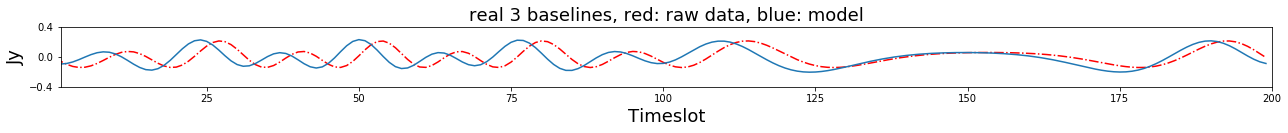

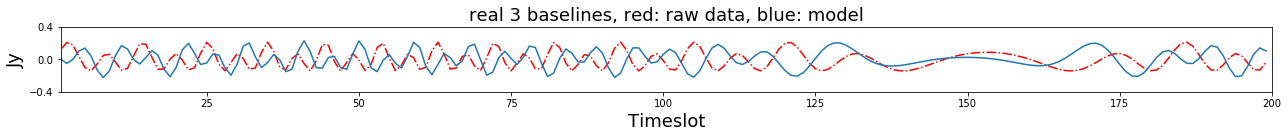

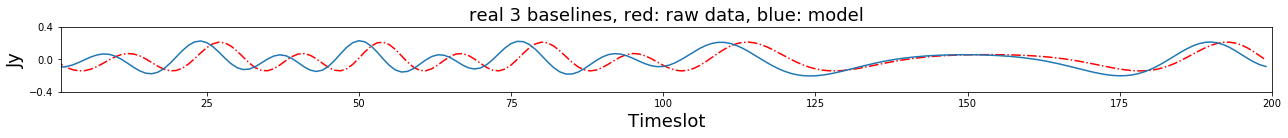

In [4]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("real {} baselines, red: raw data, blue: model".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

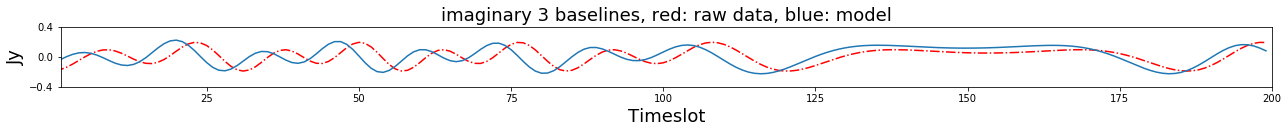

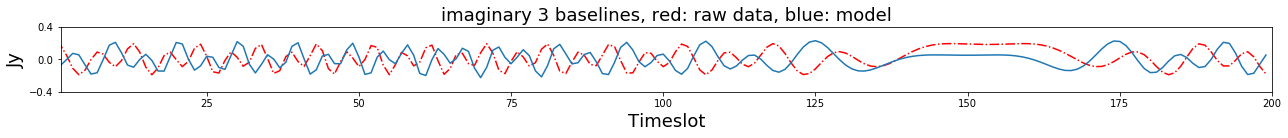

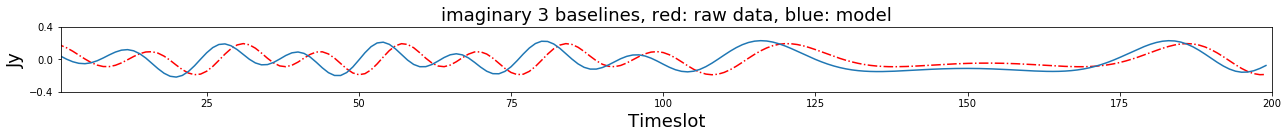

In [5]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("imaginary {} baselines, red: raw data, blue: model".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

In [6]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    d               Vector of measured values.
    u_ant, v_ant
    x               Vector of parameters. (1,3)
    r_func          Function which generates the residual vector. (1,900)
    j_func          Function which generates the (Conjugate of) Jacobian & the Hessian. 
                    (num_params,num_of_timeslots*2*num_of_baselines) & (num_of_params,num_of_params) 
    maxiter         Maximum number of iterations.
    lamda           Initial value of tuning parameter.
    K               Initial value of retuning factor.
    eps1            First tolerance parameter - triggers when residual is below this number.
    eps2            Second tolerance parameter - triggers when relative changes to the parameter
                    vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    old_chi = np.linalg.norm(r)
    olamda = lamda
#     lamda = 2
    it = 0
    
    chiplot=[]
    chiplot.append(old_chi)
    
    print("first x: ",x)
    
    x_flat= x.flatten()
    
    print("x flattened first: ",x_flat)
    solpath= x_flat
    
    print("first solpath, ", solpath)
    
    while True:
        
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        print("first  second solpath: ", solpath)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)
        print("Shape of delta_x: ",np.shape(delta_x))
        x_flat += delta_x.real
        
        solpath= np.vstack((solpath,x_flat))        
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x_flat,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x_flat) + eps2):
            return x_flat,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x_flat -= delta_x.real
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x_flat,chiplot,solpath


In [7]:
solved_x,cplot,spath = levenberg_marquardt(d,ut,vt,x_mod,pf.modfunc_res,pf.modfunc_jac)
print("solved x: ", solved_x)
print("true x: ", x_true.flatten())
print("model x: ",  x_start.flatten()) #got from up there

Shape of residual vec:  (1200,)
first x:  [[ 0.00785398  0.00872665  0.08726646]
 [ 0.0148353   0.01658063  0.13962634]]
x flattened first:  [ 0.00785398  0.00872665  0.08726646  0.0148353   0.01658063  0.13962634]
first solpath,  [ 0.00785398  0.00872665  0.08726646  0.0148353   0.01658063  0.13962634]
first  second solpath:  [ 0.00785398  0.00872665  0.08726646  0.0148353   0.01658063  0.13962634]
Shape of delta_x:  (6,)
first  second solpath:  [[ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]]
Shape of delta_x:  (6,)
first  second solpath:  [[ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.00772081  0.00877894  0.00959308  0.01482424  0.01661628 -0.01138484]]
Shape of delta_x:  (6,)
first  second solpath:  [[ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 

first  second solpath:  [[ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.00772081  0.00877894  0.00959308  0.01482424  0.01661628 -0.01138484]
 [ 0.00765423  0.00880508 -0.02924361  0.0148187   0.0166341  -0.08689043]
 [ 0.00758764  0.00883122 -0.0680803   0.01481317  0.01665192 -0.16239602]
 [ 0.00752106  0.00885737 -0.106917    0.01480764  0.01666975 -0.23790161]
 [ 0.00745447  0.00888351 -0.14575369  0.01480211  0.01668757 -0.3134072 ]
 [ 0.00738789  0.00890966 -0.18459038  0.01479658  0.01670539 -0.38891279]
 [ 0.00732131  0.0089358  -0.22342707  0.01479105  0.01672322 -0.46441838]
 [ 0.00725472  0.00896195 -0.26226376  0.01478552  0.01674104 -0.53992397]
 [ 0.00718814  0.00898809 -0.30110045  0.01477998  0.01675887 -0.61542955]
 [ 0.00712155  0.00901424 -0.33993715  0.01477445  0.01677669 -0.69093514]
 [ 0.00705497  0.00904038 -0.37877384  0.01476892  0.01679451 -0.76644073]
 

first  second solpath:  [[ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.0077874   0.00875279  0.04842977  0.01482977  0.01659845  0.06412075]
 [ 0.00772081  0.00877894  0.00959308  0.01482424  0.01661628 -0.01138484]
 [ 0.00765423  0.00880508 -0.02924361  0.0148187   0.0166341  -0.08689043]
 [ 0.00758764  0.00883122 -0.0680803   0.01481317  0.01665192 -0.16239602]
 [ 0.00752106  0.00885737 -0.106917    0.01480764  0.01666975 -0.23790161]
 [ 0.00745447  0.00888351 -0.14575369  0.01480211  0.01668757 -0.3134072 ]
 [ 0.00738789  0.00890966 -0.18459038  0.01479658  0.01670539 -0.38891279]
 [ 0.00732131  0.0089358  -0.22342707  0.01479105  0.01672322 -0.46441838]
 [ 0.00725472  0.00896195 -0.26226376  0.01478552  0.01674104 -0.53992397]
 [ 0.00718814  0.00898809 -0.30110045  0.01477998  0.01675887 -0.61542955]
 [ 0.00712155  0.00901424 -0.33993715  0.01477445  0.01677669 -0.69093514]
 [ 0.00705497  0.00904038 -0.37877384  0.01476892  0.01679451 -0.76644073]
 

first  second solpath:  [[  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.72081258e-03   8.77893558e-03   9.59307914e-03   1.48242358e-02
    1.66162754e-02  -1.13848388e-02]
 [  7.65422805e-03   8.80508025e-03  -2.92436126e-02   1.48187044e-02
    1.66340991e-02  -8.68904282e-02]
 [  7.58764352e-03   8.83122491e-03  -6.80803043e-02   1.48131730e-02
    1.66519229e-02  -1.62396018e-01]
 [  7.52105899e-03   8.85736957e-03  -1.06916996e-01   1.48076416e-02
    1.66697466e-02  -2.37901607e-01]
 [  7.45447446e-03   8.88351423e-03  -1.45753688e-01   1.48021102e-02
    1.66875704e-02  -3.13407197e-01]
 [  7.38788993e-03   8.90965890e-03  -1.84590380e-01   1.47965788e-02
    1.67053941e-02  -3.88912786e-01]
 [  7.32130540e-03   8.93580356e-03  -2.23427071e-01   1.47910474e-02
    1.67232179e-02  -4.64418376e-01]
 [  7.2547208

first  second solpath:  [[  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.72081258e-03   8.77893558e-03   9.59307914e-03   1.48242358e-02
    1.66162754e-02  -1.13848388e-02]
 [  7.65422805e-03   8.80508025e-03  -2.92436126e-02   1.48187044e-02
    1.66340991e-02  -8.68904282e-02]
 [  7.58764352e-03   8.83122491e-03  -6.80803043e-02   1.48131730e-02
    1.66519229e-02  -1.62396018e-01]
 [  7.52105899e-03   8.85736957e-03  -1.06916996e-01   1.48076416e-02
    1.66697466e-02  -2.37901607e-01]
 [  7.45447446e-03   8.88351423e-03  -1.45753688e-01   1.48021102e-02
    1.66875704e-02  -3.13407197e-01]
 [  7.38788993e-03   8.90965890e-03  -1.84590380e-01   1.47965788e-02
    1.67053941e-02  -3.88912786e-01]
 [  7.32130540e-03   8.93580356e-03  -2.23427071e-01   1.47910474e-02
    1.67232179e-02  -4.64418376e-01]
 [  7.2547208

first  second solpath:  [[  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.72081258e-03   8.77893558e-03   9.59307914e-03   1.48242358e-02
    1.66162754e-02  -1.13848388e-02]
 [  7.65422805e-03   8.80508025e-03  -2.92436126e-02   1.48187044e-02
    1.66340991e-02  -8.68904282e-02]
 [  7.58764352e-03   8.83122491e-03  -6.80803043e-02   1.48131730e-02
    1.66519229e-02  -1.62396018e-01]
 [  7.52105899e-03   8.85736957e-03  -1.06916996e-01   1.48076416e-02
    1.66697466e-02  -2.37901607e-01]
 [  7.45447446e-03   8.88351423e-03  -1.45753688e-01   1.48021102e-02
    1.66875704e-02  -3.13407197e-01]
 [  7.38788993e-03   8.90965890e-03  -1.84590380e-01   1.47965788e-02
    1.67053941e-02  -3.88912786e-01]
 [  7.32130540e-03   8.93580356e-03  -2.23427071e-01   1.47910474e-02
    1.67232179e-02  -4.64418376e-01]
 [  7.2547208

first  second solpath:  [[  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.72081258e-03   8.77893558e-03   9.59307914e-03   1.48242358e-02
    1.66162754e-02  -1.13848388e-02]
 [  7.65422805e-03   8.80508025e-03  -2.92436126e-02   1.48187044e-02
    1.66340991e-02  -8.68904282e-02]
 [  7.58764352e-03   8.83122491e-03  -6.80803043e-02   1.48131730e-02
    1.66519229e-02  -1.62396018e-01]
 [  7.52105899e-03   8.85736957e-03  -1.06916996e-01   1.48076416e-02
    1.66697466e-02  -2.37901607e-01]
 [  7.45447446e-03   8.88351423e-03  -1.45753688e-01   1.48021102e-02
    1.66875704e-02  -3.13407197e-01]
 [  7.38788993e-03   8.90965890e-03  -1.84590380e-01   1.47965788e-02
    1.67053941e-02  -3.88912786e-01]
 [  7.32130540e-03   8.93580356e-03  -2.23427071e-01   1.47910474e-02
    1.67232179e-02  -4.64418376e-01]
 [  7.2547208

In [8]:
print(spath)
print(np.shape(spath))

[[  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.78739710e-03   8.75279092e-03   4.84297709e-02   1.48297672e-02
    1.65984516e-02   6.41207507e-02]
 [  7.72081258e-03   8.77893558e-03   9.59307914e-03   1.48242358e-02
    1.66162754e-02  -1.13848388e-02]
 [  7.65422805e-03   8.80508025e-03  -2.92436126e-02   1.48187044e-02
    1.66340991e-02  -8.68904282e-02]
 [  7.58764352e-03   8.83122491e-03  -6.80803043e-02   1.48131730e-02
    1.66519229e-02  -1.62396018e-01]
 [  7.52105899e-03   8.85736957e-03  -1.06916996e-01   1.48076416e-02
    1.66697466e-02  -2.37901607e-01]
 [  7.45447446e-03   8.88351423e-03  -1.45753688e-01   1.48021102e-02
    1.66875704e-02  -3.13407197e-01]
 [  7.38788993e-03   8.90965890e-03  -1.84590380e-01   1.47965788e-02
    1.67053941e-02  -3.88912786e-01]
 [  7.32130540e-03   8.93580356e-03  -2.23427071e-01   1.47910474e-02
    1.67232179e-02  -4.64418376e-01]
 [  7.25472087e-03   8.96194822e-03  

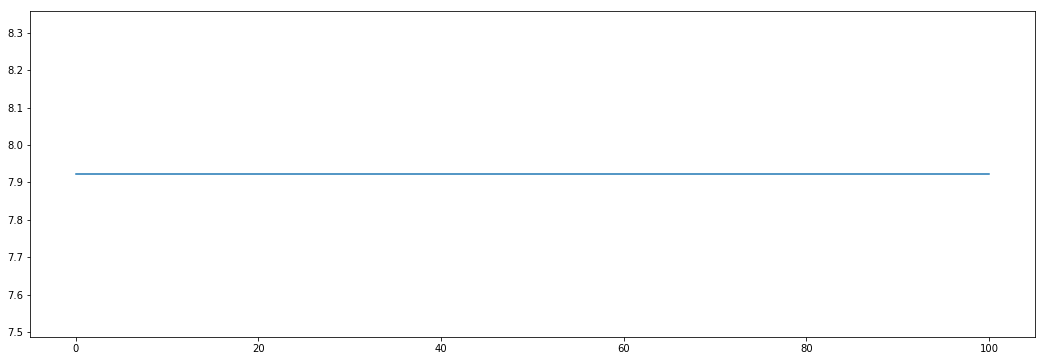

In [9]:
plt.plot(cplot)
plt.show()

In [10]:
np.shape(x_true)

(2, 3)

In [11]:
L= np.radians(np.arange(-1,1,2/timeslots))
M= np.radians(np.arange(-1,1,2/timeslots))
A= np.radians(np.arange(1,11,10/timeslots))

rr_constA= np.empty((timeslots,timeslots))
rr_constM= np.empty((timeslots,timeslots))
rr_constL= np.empty((timeslots,timeslots))

for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [L[a],M[b],x_true[:,2]]
        rr_constA[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,ut,vt,d)))
        
#         x_r= [L[a],x_true[1],A[b]]
#         rr_constM[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,ut,vt,d)))

#         x_r= [x_true[0],M[a],A[b]]
#         rr_constL[a,b]= np.square(np.linalg.norm(pf.modfunc_res(x_r,ut,vt,d)))
        
Minimum_A= np.unravel_index(np.argmin(rr_constA),rr_constA.shape)
print("Minimum of (L,M) at: ", Minimum_A)
print(rr_constA[Minimum_A])

# Minimum_M= np.unravel_index(np.argmin(rr_constM),rr_constM.shape)
# print("Minimum of (L,A) at: ", Minimum_M)
# print(rr_constM[Minimum_M])

# Minimum_L= np.unravel_index(np.argmin(rr_constL),rr_constL.shape)
# print("Minimum of (M,A) at: ",Minimum_L)
# print(rr_constL[Minimum_L])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
plt.imshow(np.flipud(rr_constA), extent=[-1,1,-1,1])
plt.plot(spath[:,1,]*180/np.pi, spath[:,0]*180/np.pi, 'w',lw=2)
plt.plot(x_true[1]*180/np.pi,x_true[0]*180/np.pi,'rx',lw=0.05)
plt.colorbar(label='$Delta$ V')
plt.grid()
plt.xlabel("m_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,M, constant A")
plt.show()

plt.plot(L*180/np.pi,rr_constA[:,Minimum_A[1]], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.title("investigating the slice along L against constant true M")
plt.show()
plt.plot(M*180/np.pi,rr_constA[Minimum_A[0],:], 'b', x_true[1]*180/np.pi,[0],'rx')
plt.title("investigating the slice along M against constant true L")
plt.show()

In [ ]:
plt.imshow(np.flipud(rr_constM), extent=[1,11,-1,1])
plt.plot(spath[:,2]*180/np.pi, spath[:,0]*180/np.pi, 'w',lw=2)
plt.plot(x_true[2]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("A_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,A, constant M")
plt.show()

plt.plot(L*180/np.pi,rr_constM[:,Minimum_M[1]], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.title("investigating the slice along M against constant true A")
plt.show()
plt.plot(A*180/np.pi,rr_constM[Minimum_M[0],:], 'b', x_true[2]*180/np.pi,[0],'rx')
plt.title("investigating the slice along A against constant true M")
plt.show()


In [ ]:
plt.imshow(np.flipud(rr_constL), extent=[1,11,-1,1])
plt.plot(spath[:,2]*180/np.pi, spath[:,1]*180/np.pi, 'w',lw=2)
plt.plot(x_true[2]*180/np.pi,x_true[1]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("A_values in degrees")
plt.ylabel("M_values in degrees")
plt.title("Contour mapping of M,A constant L")
plt.show()

plt.plot(M*180/np.pi,rr_constL[:,Minimum_L[1]], 'b', x_true[1]*180/np.pi,[0],'rx')
plt.title("investigating the slice along L against constant true A")
plt.show()
plt.plot(A*180/np.pi,rr_constL[Minimum_L[0],:], 'b', x_true[2]*180/np.pi,[0],'rx')
plt.title("investigating the slice along A against constant true L")
plt.show()


In [ ]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("real {} baselines".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),pf.modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.plot(range(timeslots),pf.modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()


In [ ]:
subps= [411,412,413,414]
baselines= [(12),(13),(14),(15),(23),(24),(25),(34),(35),(45)]

plt.figure()
for j in range(nbl):
    ax = plt.subplot(subps[np.mod(j,len(subps))])
    ax.set_title("imaginary {} baselines".format(nbl), fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),pf.modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.plot(range(timeslots),pf.modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

In [ ]:
for k in range(len(ut)):
    for i in range(k,len(ut)):
        plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
plt.title("UV tracks of baselines")
plt.show()